University of Science and Technology - CIE 425 - Fall 2020
#**JPEG Commpression Python Implemntation**
**Prepeard by: Salma Elbess 201601152**

##Introduction 

JPEG is a lossy compression algorithm that is used to compress images. JPEG is a transform coding algorithm and it is based on discrete cosine Transform. To perform JPEG on images,  the algorithm requires several steps and includes other lossless compression techniques such as Huffman and run length encoding. Different degrees of freedom in the algorithm could be tuned to control the amount of loss vs the compression ratio.This report is a python implementation of the algorithm and  we will focus on only one variable which is the quantization table. 


##Design Specs
the quantization table in thip report will be tuned to achieve the following specs: 
RMS < 0.01
, Compression ratio < 5% , SSIM > 95%

#Methedology and Implementation

In [100]:
import numpy as np
import math
from PIL import Image,ImageOps

###Encoder

1. create basis functions

In [101]:
def create_basis_functions(block_size = 8):
    """this function create the 2d disceret cosine transform basis functions
 
    Parameters:
    block_size (int): the size of the basis function is block_size X block_size
    the default is 8 
 
    Returns:
    (ndarray): ndarray of ndarrays represinting DCT basis functions. 
    axis=0,axis=1 in the output represent the u,v in the DCT equation 
    respectively and axis=0,axis=1 each basis function represents x and y in the
    DCT equation respectively.
    Each element is an ndarray with size (block_size X block_size).
    ex: output[0,0] is an ndarray of size (block_size X block_size) with u =0,
    v = 0. output[0,0][1,2] is a number resulting from the DCT equation with
    u = 0, v= 0 ,x = 1, y = 2
    """
    height,width
    x,y = np.mgrid[0:block_size,0:block_size]
    basis_functions = np.zeros((block_size,block_size),dtype = np.ndarray)
    for u in range(block_size):
        for v in range (block_size):
            basis_func = np.zeros((block_size,block_size))    
            basis_func = np.cos((2*x +1)*u*math.pi/16)*np.cos((2*y +1)*v*math.pi/16)
            basis_functions[u,v] = basis_func
    return basis_functions

2. perform block dct

In [102]:
def block_dct(basis_functions,pic_block):
    """This function performs discrete cosine transform on 8x8 block
 
    Parameters:
    basis_functions (ndarray): ndarray of ndarrays. Each element in 
    basis_functions ndarray represents one of the DCT basis functions. 
    pic_block(ndarray): ndarray with shape (8,8)
 
    Returns:
    (ndarray): DCT of pic_block with shape(8,8) 
    """
    dct = np.zeros((8,8))
    for u in range(8):
        for v in range(8):
            dct[u,v] = np.sum(np.multiply(basis_functions[u,v],pic_block))
    dct[:,0] = dct[:,0]/2
    dct[0,:] = dct[0,:]/2
    dct = dct/16
    return dct

3. Perform Block Quantization

In [103]:
def block_quantization(block,quantization_table): 
    """This function performs quantization on a block. It divides the block by a 
    quantization table and rounds the result to the nearest integer.

    Parameters:
    block (ndarray): The block to be quantized
    quantization_table(ndarray): quantization table
 
    Returns:
    (ndarray): quantized version of block with repect to the provided 
    quantization table

    NOTE: both block and quantization_table MUST have the same shape
    """
    return np.divide(block,quantization_table).round().astype('int')

4. Transform each block to 1D array using zigzag pattern

In [104]:
def two_d_2_one_d_conversion(arr):
    """convert square 2d array to 1d array using zigzag pattern
    Parameters:
    arr(ndarray): 2d array to be reshaped
    Returns:
    (ndarray): one dimensional array resulting from zigzag pattern of the 2d arr

    Note: the input 2d array MUST be square
    """
    diagonals = np.empty(2*len(arr)-1,dtype = np.ndarray)
    one_d_array = np.array([])
    for row in range(len(arr)):
        for col in range(len(arr)):
            diagonals[row+col]= np.append(diagonals[row+col],arr[row,col])
    for i in range(len(diagonals)):
        diagonals[i] =np.delete(diagonals[i],[0])
        if i%2 == 0:
            diagonals[i] =np.flip(diagonals[i])
        one_d_array = np.append(one_d_array,diagonals[i].astype('int'))
    return one_d_array.astype('int')

5. Perform run- length encoding

In [105]:
def run_length_encoder(stream):
    """perform run length encoding on one dimensional array

    Parameters:
    stream (ndarray): one dimensional array to be encoded
 
    Returns:
    (ndarray): stream input encoded by run length encoding algoritm 
    """
    encoded_stream = np.array([])
    i = 0
    while i <len(stream):
        if stream[i] != 0:
            encoded_stream = np.append(encoded_stream,stream[i])
            i+=1
        else:
            n = 0
            while i < len(stream) and stream[i] == 0:
                n+=1
                i+=1
            encoded_stream = np.append(encoded_stream,[0,n])
    return encoded_stream

6. Perform Huffman encoding

In [106]:
def Huffman_dict(letter_freq):
  """This function creates a dictionary of symbols and their corresponding 
  binary words using Huffman algorithm.
 
  Parameters:
  letter_freq (dict): symbols as the dict keys and their frequinces as the 
  dict values
 
  Returns:
  (dict):dictionary with symbols as the dict keys and their corresponding 
  huffman encoded binary word as the dict values

  Credits: The initial version of this function is made in our project part 1
  Then, it is modified to fit integer arrays by Asmaa Ibrahim 201701056
  """
 
  let_freq = letter_freq.copy() # make a copy of the dictionary to keep the original unchanged
  print(let_freq)
  alphabets = let_freq.keys() 
  codes = {alphabet: '' for alphabet in alphabets} # a new dictionary of all the letters intiated to value of empty string
  while len(let_freq) > 1: 
    key_min = min(let_freq.keys(), key= lambda k: let_freq[k]) # gets the key of the lowest value 
    val_min = let_freq[key_min]
    del let_freq[key_min] # deletes that item
    key_min2 = min(let_freq.keys(), key= lambda k: let_freq[k]) # second lowest value 
    val_min2 = let_freq[key_min2]
    del let_freq[key_min2] # deletes 
    new_key = key_min + key_min2 # concatenates the two minimum keys together
    let_freq[new_key] = val_min + val_min2 # add a new item to the list containing the new key with the summation of the 2 minima value
    for i in range(0,len(key_min),3):
      codes[key_min[i:i+3]] ='1' + codes[key_min[i:i+3]] # adds zero to the code of the letters of the lowest key
    for i in range(0,len(key_min2),3):
      codes[key_min2[i:i+3]] ='0' + codes[key_min2[i:i+3]] #adds one to the code of the letters of the 2nd lowest key
  return codes

In [107]:
def huffman_image_encoder(image_array):
  """This function encodes one dimensional array of integers into binary stream
  using Huffman algorithm
 
  Parameters:
  image_array (ndarray): one dimensional array of integres to be encoded
 
  Returns:
  (ndarray): stream of zeros and ones. The binary representation of the input 
  array using huffman encoding 
  (dict):dictionary with symbols as the dict keys and their corresponding 
  huffman encoded binary word as the dict values

  Credits: The initial version of this function is made in our project part 1
  Then, it is modified to fit integer arrays by Asmaa Ibrahim 201701056
  """
  ## changing array format to string with three digit numbers
  size = image_array.size
  image_array = image_array.astype(str)
  image_array = np.char.zfill(image_array,3)
  ## optaining numbers probability in a dictionary
  num_freq = {}
  num, counts = np.unique(image_array, return_counts=True)
  num = num.astype(str)
  num = np.char.zfill(num,3)
  freq = np.divide(counts,size)
  num_freq= dict(zip(num, freq))
  print(num_freq)
  ## obtaining huffman codes
  codes = Huffman_dict(num_freq)
  print(codes)
  ## encoding
  encoded_image = ''
  image_array = image_array.astype(str)
  print(image_array.shape)
  for i in image_array:
      encoded_image += codes[i]
  
  return encoded_image,codes

###Decoder

1. Perform Huffman decosing

In [108]:
def huffman_image_decoder(encoded_image_array,codes):
  """This function decodes a binary one dimensional array to integer array using 
  Huffman encoding
 
  Parameters:
  encoded_image (ndarray): one dimensional binary array 
  codes (dict):dictionary with symbols as the dict keys and their corresponding 
  huffman encoded binary word as the dict values
  Returns:
  (ndarray): array of integers
  

  Credits: The initial version of this function is made in our project part 1
  Then, it is modified to fit integer arrays by Asmaa Ibrahim 201701056
  """
  #get the letters their huffman codes into 2 arrays (array of letters,
  #array of values) with corresponding indeces
  nums = list(codes.keys())
  binary_words = list(codes.values())
  # start decosing
  candidate_bin_words = list(codes.values()) #start with all the binary word
  word_index = 0 #start of word
  stream_index = 0 #start of the stream
  decoded_stream = np.empty(0) #empty decoded_stream
  while stream_index <= (len(encoded_image_array)):
      if len(candidate_bin_words)>1: #if there is more than one candidate symbol ---> still nor the end of the binary word
          bit = encoded_image_array[stream_index] #current bit the stream
          #eliminate words that do not contain current stream bit in the right index 
          #equavilant to elemenating branch from Huffman binary tree and searching in the other branch
          candidate_bin_words =  [b for b in candidate_bin_words if  b[word_index] == bit] 
          word_index +=1
          stream_index +=1
          #repeat until there is only one candidate ---> end of binary word 
      else: 
          decoded_stream = np.append(decoded_stream,nums[binary_words.index(candidate_bin_words[0])]) # get the symbol corresponding to the signle binary candidate and add it to the decoded stream
          word_index = 0 #start a new word
          candidate_bin_words = list(codes.values()) #set all the binary words as candidate for the new word in the stream
          if stream_index == len(encoded_image_array): #break at the end of the encoded stream
              break
  return decoded_stream.astype('float')

2. Perform Run-length Decoding 

In [109]:
def run_length_decoder(encoded_stream):
    """perform run length decoding on one dimensional array  
    Parameters:
    encoded_stream (ndarray): one dimensional array to be decoded
 
    Returns:
    (ndarray): one dimensional array of encoded_stream decoded by run length 
    decoding algoritm 
    """
    decoded_stream = np.array([])
    i = 0
    while i < len(encoded_stream):
        if encoded_stream[i] == 0:
            n = encoded_stream[i+1]
            decoded_stream = np.append(decoded_stream,np.zeros(int(n)))
            i +=2
        else:
            decoded_stream = np.append(decoded_stream,encoded_stream[i])
            i+=1
    return decoded_stream

3. Covert 1D arrays to 2D arrays using zigzag pattern

In [110]:
def one_d_2_two_d_conversion(one_d_array):
    """convert 1d array to 2d square array using zigzag pattern
    Parameters:
    arr(ndarray): 1d array to be reshaped
    Returns:
    (ndarray): two dimensional array resulting from zigzag pattern reshaping of 
    the 1d array
    """
    one_d_list = list(one_d_array)
    size = int(math.sqrt(len(one_d_array)))
    diagonals = np.empty(2*size-1,dtype = np.ndarray)
    two_d_array = np.zeros([size,size])
    for i in range(len(diagonals)):
        if i < size :
            for j in range(i+1):
                diagonals[i] = np.append(diagonals[i],one_d_list.pop(0))
        else:
            for j in range(2*size-(i+1)):
                diagonals[i] = np.append(diagonals[i],one_d_list.pop(0))
        diagonals[i] =np.delete(diagonals[i],[0])
        if i%2 == 0:
            diagonals[i] =np.flip(diagonals[i])
    for row in range(size):
        for col in range(size):
            two_d_array[row,col]= diagonals[row+col][0]
            diagonals[row+col]= np.delete(diagonals[row+col],0)
    return two_d_array.astype('int')

5. Multiply image blocks by quantization table (code inside the script)

6. Perform Block by Block IDCT

In [111]:
def block_idct(basis_functions,block_dct):
    """This function performs inverse discrete cosine transform on 8x8 block
 
    Parameters:
    basis_functions (ndarray): ndarray of ndarrays. Each element in 
    basis_functions ndarray represents one of the DCT basis functions. 
    block_dct(ndarray): ndarray with shape (8,8)
 
    Returns:
    (ndarray): IDCT of block_dct with shape(8,8) 
    """
    recovered_photo = np.zeros((8,8))
    for u in range(8):
        for v in range(8):
            recovered_photo = recovered_photo + np.multiply(basis_functions[u,v],block_dct[u,v])
    return recovered_photo

###Evaluation


The algoritm is evaluated using RMS, SSMI, and compression Ratio

##Testing and Results

Two different quantization tables are used to test JPEG algorithm on monalisa grey image

###Test 1

In [112]:
quantization_table2 = np.array([[1, 2 ,4 ,8 ,16, 32, 64 ,128],[2 ,4 ,4 ,8 ,16 ,32 ,64 ,128],[4 ,4 ,8 ,16 ,32 ,64 ,128 ,128],[8 ,8 ,16 ,32 ,64 ,128 ,128 ,256],[16 ,16 ,32 ,64 ,128 ,128 ,256 ,256],[32 ,32 ,64 ,128 ,128 ,256 ,256 ,256],[64 ,64 ,128 ,128 ,256 ,256 ,256 ,256],[128 ,128 ,128 ,256 ,256 ,256 ,256 ,256]])

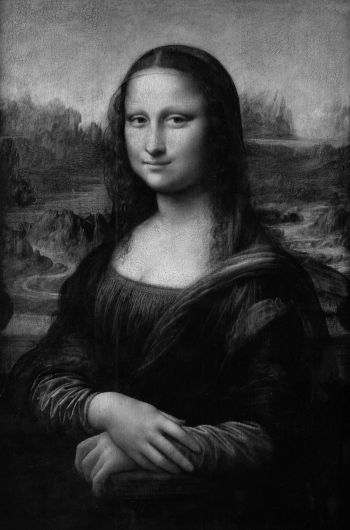

In [113]:
## open the image and crop it so the dimensions are dividable by the block size
img = Image.open("Mona_Lisa_GS2.jpg")
img = ImageOps.grayscale(img)
img

In [114]:

img = np.array(img)
height,width = img.shape
img = img[height%8:,width%8:]
height, width = img.shape

###ENCODER
#create basis functions 
basis_functions = create_basis_functions()

#Perform block by block DCT 
pic_dct = np.zeros((height//8,width//8),dtype = np.ndarray)
for i in range(height//8):
    for j in range(width//8):
        pic_block = img[i*8:i*8+8,j*8:j*8+8]
        pic_dct[i,j] = block_dct(basis_functions,pic_block)
#Perform quantization and Block conversion to 1D array using zigzag pattern 
pic_quantization = np.zeros((height//8,width//8),dtype = np.ndarray)
stream = np.empty((height*width))
index = 0
for i in range(height//8):
    for j in range(width//8):
        #Quantization
        pic_quantization[i,j] = block_quantization(pic_dct[i,j],quantization_table2)
        #2D to 1D using zigzag pattern
        stream[index:index+64] = two_d_2_one_d_conversion(pic_quantization[i,j])
        index+=64

#run length encoding
stream_rl_encoded = run_length_encoder(stream)

#Huffman encoding
huffman_encoded,codes = huffman_image_encoder(stream_rl_encoded)

###DECODER
#Perform Huffman decoding
huffman_decoded = huffman_image_decoder(huffman_encoded,codes)
#Perform run length decoding
stream_rl_decoded = run_length_decoder(huffman_decoded)

# 1D to 2D conversion and multiplication by the quantization table
pic_decoding = np.zeros((height//8,width//8),dtype = np.ndarray)
index = 0
for i in range(height//8):
    for j in range(width//8):
        # 1D to 2D
        pic_decoding[i,j]= one_d_2_two_d_conversion(stream_rl_decoded[index:index+64])
        index+=64
        # multiply by quantization table
        pic_decoding[i,j] = np.multiply(pic_decoding[i,j],quantization_table2).astype('int')
#Perform IDCT
recovered_img = np.zeros(((height//8)*8,(width//8)*8))
for i in range(height//8):
    for j in range(width//8):
        recovered_img[i*8:i*8+8,j*8:j*8+8] = block_idct(basis_functions,pic_dct[i,j]) 
im = Image.fromarray(np.round(recovered_img).astype('uint8'))


{'-1.': 0.12016647137258071, '-10': 0.000888924805042628, '-11': 0.0011717645157380096, '-12': 0.0005252737484342802, '-13': 0.0004848680754777971, '-14': 0.00016162269182593236, '-15': 0.00036365105660834783, '-16': 0.0004040567295648309, '-17': 0.00020202836478241544, '-18': 0.00020202836478241544, '-19': 0.00016162269182593236, '-2.': 0.03212251000040406, '-20': 0.00012121701886944927, '-21': 0.00016162269182593236, '-22': 0.00020202836478241544, '-23': 0.00024243403773889854, '-24': 4.040567295648309e-05, '-25': 0.00012121701886944927, '-27': 8.081134591296618e-05, '-28': 4.040567295648309e-05, '-29': 8.081134591296618e-05, '-3.': 0.01543496706937654, '-30': 4.040567295648309e-05, '-33': 8.081134591296618e-05, '-4.': 0.007394238151036406, '-5.': 0.004242595660430724, '-6.': 0.0029900197987797485, '-7.': 0.002262717685563053, '-8.': 0.0014546042264333913, '-9.': 0.001292981534607459, '0.0': 0.2463533880156774, '1.0': 0.18627015232938704, '10.': 0.004525435371126106, '100': 8.0811345

####Result 

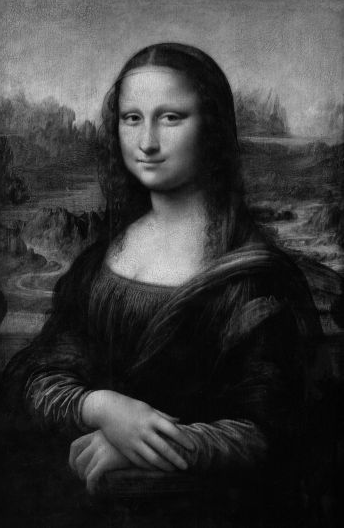

In [115]:
im

####Evaluation

In [116]:
compression_ratio = len(huffman_encoded)*100/(height*width*8)
print('Compression Ration is ',compression_ratio,'%')

Compression Ration is  7.510171665785765 %


In [117]:
print('RMS is',math.sqrt(np.sum(np.power(recovered_img- img,2))/(height*width)))

RMS is 5.323090849414893e-14


In [118]:
#reference  https://bit.ly/3410T3f
from skimage.measure import compare_ssim
(score, diff) = compare_ssim(recovered_img, img, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))

SSIM: 0.9999999999968049


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


**The compression ratio is not satisfied so we will perform higher compression by having quantization table with bigger values**

###Test 2

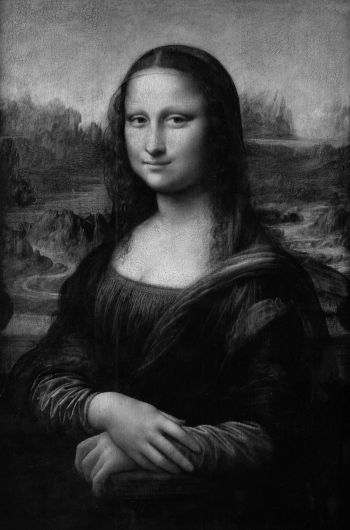

In [120]:
## open the image and crop it so the dimensions are dividable by the block size
img = Image.open("Mona_Lisa_GS2.jpg")
img = ImageOps.grayscale(img)
img

In [121]:
quantization_table2 = quantization_table2*3

In [122]:

img = np.array(img)
height,width = img.shape
img = img[height%8:,width%8:]
height, width = img.shape

###ENCODER
#create basis functions 
basis_functions = create_basis_functions()

#Perform block by block DCT 
pic_dct = np.zeros((height//8,width//8),dtype = np.ndarray)
for i in range(height//8):
    for j in range(width//8):
        pic_block = img[i*8:i*8+8,j*8:j*8+8]
        pic_dct[i,j] = block_dct(basis_functions,pic_block)
#Perform quantization and Block conversion to 1D array using zigzag pattern 
pic_quantization = np.zeros((height//8,width//8),dtype = np.ndarray)
stream = np.empty((height*width))
index = 0
for i in range(height//8):
    for j in range(width//8):
        #Quantization
        pic_quantization[i,j] = block_quantization(pic_dct[i,j],quantization_table2)
        #2D to 1D using zigzag pattern
        stream[index:index+64] = two_d_2_one_d_conversion(pic_quantization[i,j])
        index+=64

#run length encoding
stream_rl_encoded = run_length_encoder(stream)

#Huffman encoding
huffman_encoded,codes = huffman_image_encoder(stream_rl_encoded)

###DECODER
#Perform Huffman decoding
huffman_decoded = huffman_image_decoder(huffman_encoded,codes)
#Perform run length decoding
stream_rl_decoded = run_length_decoder(huffman_decoded)

# 1D to 2D conversion and multiplication by the quantization table
pic_decoding = np.zeros((height//8,width//8),dtype = np.ndarray)
index = 0
for i in range(height//8):
    for j in range(width//8):
        # 1D to 2D
        pic_decoding[i,j]= one_d_2_two_d_conversion(stream_rl_decoded[index:index+64])
        index+=64
        # multiply by quantization table
        pic_decoding[i,j] = np.multiply(pic_decoding[i,j],quantization_table2).astype('int')
#Perform IDCT
recovered_img = np.zeros(((height//8)*8,(width//8)*8))
for i in range(height//8):
    for j in range(width//8):
        recovered_img[i*8:i*8+8,j*8:j*8+8] = block_idct(basis_functions,pic_dct[i,j]) 
im = Image.fromarray(np.round(recovered_img).astype('uint8'))


{'-1.': 0.0921409214092141, '-10': 0.0002032520325203252, '-11': 0.00013550135501355014, '-2.': 0.01592140921409214, '-3.': 0.006097560975609756, '-4.': 0.003658536585365854, '-5.': 0.0015582655826558267, '-6.': 0.000948509485094851, '-7.': 0.0008130081300813008, '-8.': 0.0006775067750677507, '-9.': 0.0002032520325203252, '0.0': 0.27723577235772356, '1.0': 0.14552845528455285, '10.': 0.004336043360433604, '11.': 0.003184281842818428, '12.': 0.002845528455284553, '13.': 0.0033875338753387536, '14.': 0.0035230352303523035, '15.': 0.0035230352303523035, '16.': 0.0033197831978319784, '17.': 0.0035230352303523035, '18.': 0.0032520325203252032, '19.': 0.002168021680216802, '2.0': 0.05067750677506775, '20.': 0.002913279132791328, '21.': 0.0023035230352303525, '22.': 0.0024390243902439024, '23.': 0.002168021680216802, '24.': 0.0022357723577235773, '25.': 0.0016937669376693768, '26.': 0.0012872628726287264, '27.': 0.0012195121951219512, '28.': 0.0015582655826558267, '29.': 0.0012195121951219512

####Result 

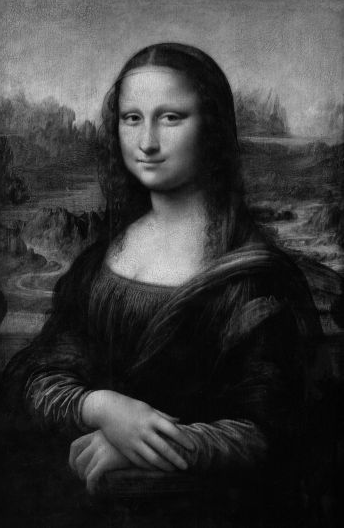

In [123]:
im

####Evaluation

In [124]:
compression_ratio = len(huffman_encoded)*100/(height*width*8)
print('Compression Ration is ',compression_ratio,'%')

Compression Ration is  4.213464587737843 %


In [125]:
print('RMS is',math.sqrt(np.sum(np.power(recovered_img- img,2))/(height*width)))

RMS is 5.323090849414893e-14


In [126]:
#reference  https://bit.ly/3410T3f
from skimage.measure import compare_ssim
(score, diff) = compare_ssim(recovered_img, img, full=True)
diff = (diff * 255).astype("uint8")

# 6. You can print only the score if you want
print("SSIM: {}".format(score))

SSIM: 0.9999999999968049


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


**Better compression ratio and the other 2 specs still satisfied so the second result will be chosen and saves** 

In [127]:
im = im.save('monalisa_test.jpg')